<img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P7: Implémentez un modèle de scoring </span></font> </center>  

***

<font size="3"> <span style="font-size: 1.5em" > **Partie 2 : Modélisation** </span> </font> 

**Contexte**  
**Prêt à dépenser** est une société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
<img src="pretadepenser.png" width="200" height="200">
**Mission**   
* Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
* Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
* Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.

Dans ce notebook, nous allos:
* Résoudre le problème de désiquilibre entre les classes.
* Implémenter un modèle de machine learning
* Chercher les meilleurs hyperparamètres par gridsearchCV
* .....

# Importation des données et des librairies Python pour DS

In [87]:
# ------------------------------------------
# Projet : Implémenter un modèle de scoring
# Données: https://www.kaggle.com/c/home-credit-default-risk/data
# Auteur : Rim BAHROUN
# Date: Avril 2023
# OpenClassrooms
# -------------------------------------------
# importation des librairies Python pour DS
# -------------------------------------------
import os
import csv
import numpy as np
import pandas as pd
import re
import gc
import time
from contextlib import contextmanager
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import make_scorer, f1_score, fbeta_score, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.linear_model import LogisticRegression

In [86]:
import sys
print(sys.executable)

C:\ProgramData\Anaconda3\python.exe


In [63]:
%matplotlib inline
np.random.seed(27)
rcParams['figure.figsize'] = 10, 6
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
train_df = pd.read_csv('data/traited/df_train_35.csv')

In [4]:
train_df.head()

,EXT_SOURCE_2,PREV_DAYS_DECISION_MEAN,BURO_MONTHS_BALANCE_SIZE_MEAN,DAYS_REGISTRATION,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,REGION_POPULATION_RELATIVE,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,BURO_DAYS_CREDIT_MAX,POS_MONTHS_BALANCE_MEAN,BURO_CREDIT_TYPE_Creditcard_MEAN,CLOSED_DAYS_CREDIT_MAX,BURO_STATUS_0_MEAN_MEAN,HOUR_APPR_PROCESS_START,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,PREV_NAME_TYPE_SUITE_nan_MEAN,CLOSED_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MIN,EXT_SOURCE_3,EXT_SOURCE_1,BURO_DAYS_CREDIT_MEAN,DAYS_BIRTH,BURO_CREDIT_ACTIVE_Active_MEAN,ACTIVE_DAYS_CREDIT_MAX,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,DAYS_LAST_PHONE_CHANGE,REFUSED_DAYS_DECISION_MAX,ACTIVE_DAYS_CREDIT_MEAN,PREV_DAYS_DECISION_MIN,DAYS_ID_PUBLISH,TARGET,SK_ID_CURR
0,0.262949,-606.000000,13.75,-3648.0,1.000000,0.000000,0.018801,0.000000,-103.0,-10.000000,0.5,-476.0,0.406960,10,1.000000,0.000000,3960000.0,1.000000,-974.500000,-1042.0,-1437.0,0.139376,0.083037,-874.000000,-9461,0.250,-103.0,1.000000,-1134.0,-396.0,-572.500000,-606.0,-2120,1.0,100002
1,0.622246,-1305.000000,24.75,-1186.0,0.333333,0.000000,0.003541,0.666667,-606.0,-43.785714,0.5,-775.0,0.436423,11,0.666667,0.333333,3960000.0,0.000000,-1665.666667,-606.0,-2586.0,0.535276,0.311267,-1400.750000,-16765,0.250,-606.0,1.000000,-828.0,-396.0,-606.000000,-2341.0,-291,0.0,100003
2,0.555912,-815.000000,24.75,-4260.0,0.000000,0.000000,0.010032,1.000000,-408.0,-25.500000,0.0,-408.0,0.436423,9,1.000000,0.000000,3960000.0,0.000000,-867.000000,-764.0,-1326.0,0.729567,0.505998,-867.000000,-19046,0.000,-258.0,1.000000,-815.0,-396.0,-537.309524,-815.0,-2531,0.0,100004
3,0.650442,-272.444444,24.75,-9833.0,0.222222,0.222222,0.008019,0.444444,-300.0,-9.619048,0.2,-729.0,0.436423,17,0.555556,0.111111,1620000.0,0.555556,-1366.555556,-764.0,-1827.0,0.535276,0.505998,-1050.571429,-19005,0.375,-258.0,0.555556,-617.0,-181.0,-537.309524,-617.0,-2437,0.0,100006
4,0.322738,-1222.833333,24.75,-4311.0,0.000000,0.500000,0.028663,0.833333,-1149.0,-33.636364,0.0,-1149.0,0.436423,11,0.333333,0.500000,3960000.0,0.333333,-1149.000000,-764.0,-1149.0,0.535276,0.505998,-1149.000000,-19932,0.000,-258.0,1.000000,-1106.0,-396.0,-537.309524,-2357.0,-3458,0.0,100007


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Data columns (total 35 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   EXT_SOURCE_2                                        307507 non-null  float64
 1   PREV_DAYS_DECISION_MEAN                             307507 non-null  float64
 2   BURO_MONTHS_BALANCE_SIZE_MEAN                       307507 non-null  float64
 3   DAYS_REGISTRATION                                   307507 non-null  float64
 4   PREV_NAME_YIELD_GROUP_low_normal_MEAN               307507 non-null  float64
 5   PREV_NAME_YIELD_GROUP_high_MEAN                     307507 non-null  float64
 6   REGION_POPULATION_RELATIVE                          307507 non-null  float64
 7   PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN      307507 non-null  float64
 8   BURO_DAYS_CREDIT_MAX                                307507 non-n

In [6]:
train_df_99 = pd.read_csv('data/traited/df_train_99.csv')

In [7]:
train_df_na = train_df_99.loc[:, train_df.columns]

In [8]:
train_df_na.head()

,EXT_SOURCE_2,PREV_DAYS_DECISION_MEAN,BURO_MONTHS_BALANCE_SIZE_MEAN,DAYS_REGISTRATION,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,REGION_POPULATION_RELATIVE,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,BURO_DAYS_CREDIT_MAX,POS_MONTHS_BALANCE_MEAN,BURO_CREDIT_TYPE_Creditcard_MEAN,CLOSED_DAYS_CREDIT_MAX,BURO_STATUS_0_MEAN_MEAN,HOUR_APPR_PROCESS_START,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,PREV_NAME_TYPE_SUITE_nan_MEAN,CLOSED_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MIN,EXT_SOURCE_3,EXT_SOURCE_1,BURO_DAYS_CREDIT_MEAN,DAYS_BIRTH,BURO_CREDIT_ACTIVE_Active_MEAN,ACTIVE_DAYS_CREDIT_MAX,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,DAYS_LAST_PHONE_CHANGE,REFUSED_DAYS_DECISION_MAX,ACTIVE_DAYS_CREDIT_MEAN,PREV_DAYS_DECISION_MIN,DAYS_ID_PUBLISH,TARGET,SK_ID_CURR
0,0.262949,-606.000000,13.75,-3648.0,1.000000,0.000000,0.018801,0.000000,-103.0,-10.000000,0.5,-476.0,0.40696,10,1.000000,0.000000,NaN,1.000000,-974.500000,-1042.0,-1437.0,0.139376,0.083037,-874.00,-9461,0.25,-103.0,1.000000,-1134.0,NaN,-572.5,-606.0,-2120,1.0,100002
1,0.622246,-1305.000000,NaN,-1186.0,0.333333,0.000000,0.003541,0.666667,-606.0,-43.785714,0.5,-775.0,NaN,11,0.666667,0.333333,NaN,0.000000,-1665.666667,-606.0,-2586.0,NaN,0.311267,-1400.75,-16765,0.25,-606.0,1.000000,-828.0,NaN,-606.0,-2341.0,-291,0.0,100003
2,0.555912,-815.000000,NaN,-4260.0,0.000000,0.000000,0.010032,1.000000,-408.0,-25.500000,0.0,-408.0,NaN,9,1.000000,0.000000,NaN,0.000000,-867.000000,NaN,-1326.0,0.729567,NaN,-867.00,-19046,0.00,NaN,1.000000,-815.0,NaN,NaN,-815.0,-2531,0.0,100004
3,0.650442,-272.444444,NaN,-9833.0,0.222222,0.222222,0.008019,0.444444,NaN,-9.619048,NaN,NaN,NaN,17,0.555556,0.111111,1620000.0,0.555556,NaN,NaN,NaN,NaN,NaN,NaN,-19005,NaN,NaN,0.555556,-617.0,-181.0,NaN,-617.0,-2437,0.0,100006
4,0.322738,-1222.833333,NaN,-4311.0,0.000000,0.500000,0.028663,0.833333,-1149.0,-33.636364,0.0,-1149.0,NaN,11,0.333333,0.500000,NaN,0.333333,-1149.000000,NaN,-1149.0,NaN,NaN,-1149.00,-19932,0.00,NaN,1.000000,-1106.0,NaN,NaN,-2357.0,-3458,0.0,100007


In [9]:
train_df_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Data columns (total 35 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   EXT_SOURCE_2                                        306847 non-null  float64
 1   PREV_DAYS_DECISION_MEAN                             291053 non-null  float64
 2   BURO_MONTHS_BALANCE_SIZE_MEAN                       92231 non-null   float64
 3   DAYS_REGISTRATION                                   307507 non-null  float64
 4   PREV_NAME_YIELD_GROUP_low_normal_MEAN               291053 non-null  float64
 5   PREV_NAME_YIELD_GROUP_high_MEAN                     291053 non-null  float64
 6   REGION_POPULATION_RELATIVE                          307507 non-null  float64
 7   PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN      291053 non-null  float64
 8   BURO_DAYS_CREDIT_MAX                                263487 non-n

In [19]:
target = 'TARGET'

In [128]:
X = train_df.loc[:, train_df.columns!=target]
Y = train_df.loc[:, train_df.columns==target]

In [21]:
X_na = train_df_na.loc[:, train_df_na.columns!=target]

In [129]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [23]:
X_train_na, X_valid_na, Y_train_na, Y_valid_na = train_test_split(X_na, Y, 
                                                                test_size=0.33, 
                                                                random_state=42)

In [130]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_valid_std = scaler.transform(X_valid)

In [35]:
Y_train = Y_train.values.ravel()
#clf = LogisticRegression().fit(X_train_std, Y_train)

In [152]:
clf = LGBMClassifier( #nthread=4,
                        n_estimators=10000,
                        learning_rate=0.02,
                        num_leaves=34,
                        colsample_bytree=0.9497036,
                        subsample=0.8715623,
                        max_depth=8,
                        reg_alpha=0.041545473,
                        reg_lambda=0.0735294,
                        min_split_gain=0.0222415,
                        min_child_weight=39.3259775,
                        verbose=-1, )

# Fonctions utiles

In [54]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy = {:.3f}".format(accuracy_score(y_actual, y_predicted)))
    print("Precision = {:.3f}".format(precision_score(y_actual, y_predicted)))
    print("Recall = {:.3f}".format(recall_score(y_actual, y_predicted)))
    print("F1 Score = {:.3f}".format(f1_score(y_actual, y_predicted)))
    print("Fbeta Score = {:.3f}".format(fbeta_score(y_actual, y_predicted, beta=3.16)))
    pass

In [58]:
def generate_auc_roc_curve(clf, X_test, Y_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  y_pred_proba)
    auc = roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

# Equilibrer les classes 

0.0    0.91927
1.0    0.08073
Name: TARGET, dtype: float64


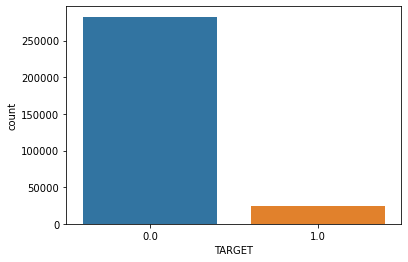

In [13]:
ax = sns.countplot(x='TARGET', data=train_df)
print(train_df['TARGET'].value_counts(normalize=True))

In [153]:
clf.fit(X_train_std, Y_train)

LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, num_leaves=34, reg_alpha=0.041545473,
               reg_lambda=0.0735294, subsample=0.8715623, verbose=-1)

In [154]:
Y_valid_pred = clf.predict(X_valid_std)

In [155]:
print("Validation:")
pd.crosstab(Y_valid_pred, Y_valid[target], rownames=['Predicted'], colnames=['Actual'])

Validation:


Actual,0.0,1.0
Predicted,,
0.0,92864,7876
1.0,444,294


In [156]:
generate_model_report(Y_valid, Y_valid_pred)

Accuracy = 0.918
Precision = 0.398
Recall = 0.036
F1 Score = 0.066
Fbeta Score = 0.039


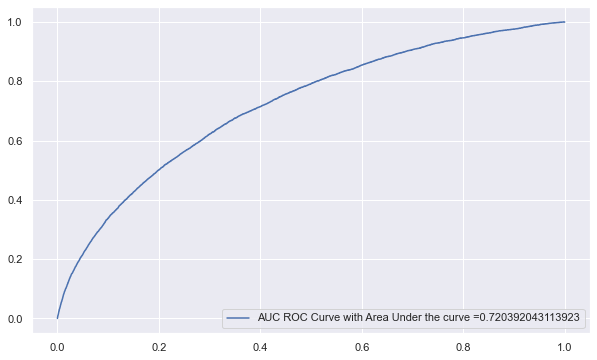

In [157]:
generate_auc_roc_curve(clf, X_valid_std, Y_valid)

## Random undersampling

In [158]:
target = 'TARGET'
df = pd.DataFrame(X_train_std, columns=X_train.columns)
df[target] = Y_train
minority_class_len = len(df[df[target] == 1])
print(minority_class_len)

11217


In [159]:
majority_class_indices = df[df[target] == 0].index

In [160]:
random_majority_indices = np.random.choice(majority_class_indices,
                                           minority_class_len, 
                                           replace=False)
print(len(random_majority_indices))

11217


In [161]:
minority_class_indices = df[df[target] == 1].index

In [162]:
under_sample_indices = np.concatenate([minority_class_indices,random_majority_indices])

In [163]:
under_sample = df.loc[under_sample_indices]

In [164]:
under_sample[target].value_counts()

1.0    11217
0.0    11217
Name: TARGET, dtype: int64

In [165]:
X_train_std_us = under_sample.loc[:, df.columns!=target]
Y_train_us = under_sample.loc[:, df.columns==target]

clf_us = clf.fit(X_train_std_us, Y_train_us)
Y_valid_us_pred = clf_us.predict(X_valid_std)

In [166]:
print("Validation:")
pd.crosstab(Y_valid_us_pred, Y_valid[target], rownames=['Predicted'], colnames=['Actual'])

Validation:


Actual,0.0,1.0
Predicted,,
0.0,46741,4247
1.0,46567,3923


In [167]:
generate_model_report(Y_valid, Y_valid_us_pred)

Accuracy = 0.499
Precision = 0.078
Recall = 0.480
F1 Score = 0.134
Fbeta Score = 0.326


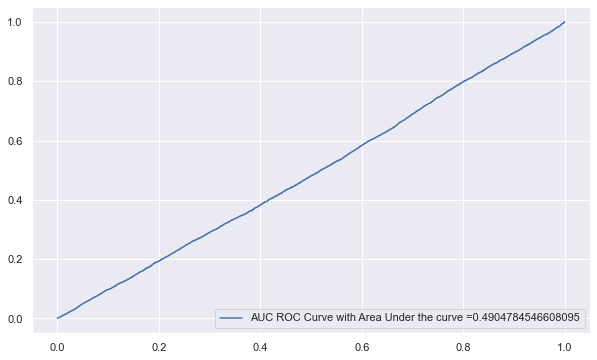

In [168]:
generate_auc_roc_curve(clf_us, X_valid_std, Y_valid)

## class_weight='balanced'

In [170]:
clf_cw = LGBMClassifier(
                        #nthread=4,
                        n_estimators=10000,
                        learning_rate=0.02,
                        num_leaves=34,
                        colsample_bytree=0.9497036,
                        subsample=0.8715623,
                        max_depth=8,
                        reg_alpha=0.041545473,
                        reg_lambda=0.0735294,
                        min_split_gain=0.0222415,
                        min_child_weight=39.3259775,
                        verbose=-1, 
                        class_weight='balanced').fit(X_train_std, Y_train)

In [171]:
Y_valid_pred = clf_cw.predict(X_valid_std)

In [172]:
print("Validation:")
pd.crosstab(Y_valid_pred, Y_valid[target], rownames=['Predicted'], colnames=['Actual'])

Validation:


Actual,0.0,1.0
Predicted,,
0.0,81902,5094
1.0,11406,3076


In [173]:
generate_model_report(Y_valid, Y_valid_pred)

Accuracy = 0.837
Precision = 0.212
Recall = 0.376
F1 Score = 0.272
Fbeta Score = 0.352


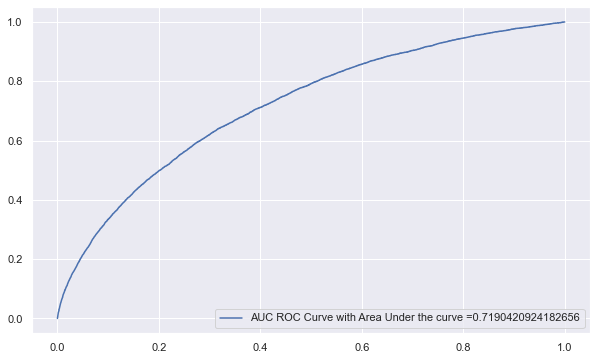

In [174]:
generate_auc_roc_curve(clf_cw, X_valid_std, Y_valid)

In [73]:
# Define fbeta scorer with beta=3.16
scorer = make_scorer(fbeta_score, beta=3.16)

weights = np.linspace(0.05, 0.95, 20)
gsc = GridSearchCV(
    estimator=LGBMClassifier(
                        #nthread=4,
                        n_estimators=10000,
                        learning_rate=0.02,
                        num_leaves=34,
                        colsample_bytree=0.9497036,
                        subsample=0.8715623,
                        max_depth=8,
                        reg_alpha=0.041545473,
                        reg_lambda=0.0735294,
                        min_split_gain=0.0222415,
                        min_child_weight=39.3259775,
                        verbose=-1),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring=scorer,
    cv=5
)

grid_result = gsc.fit(X_train, Y_train)
print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'class_weight': {0: 0.05, 1: 0.95}}


<AxesSubplot:xlabel='weight'>

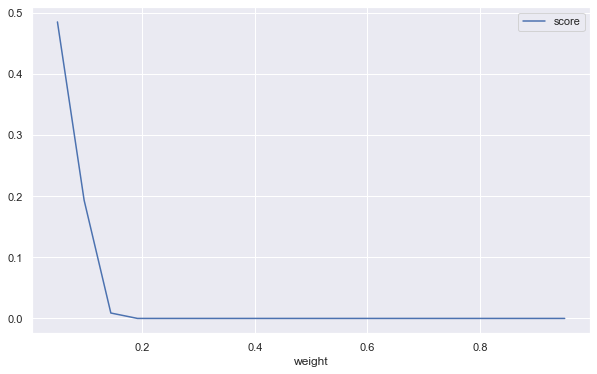

In [74]:
data_out = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
data_out.plot(x='weight')

In [76]:
clf = LogisticRegression(**grid_result.best_params_).fit(X_train_std, Y_train)

In [77]:
Y_valid_pred = clf.predict(X_valid_std)

In [78]:
print("Validation:")
pd.crosstab(Y_valid_pred, Y_valid[target], rownames=['Predicted'], colnames=['Actual'])

Validation:


Actual,0.0,1.0
Predicted,,
0.0,42811,1354
1.0,50497,6816


In [79]:
generate_model_report(Y_valid, Y_valid_pred)

Accuracy = 0.489
Precision = 0.119
Recall = 0.834
F1 Score = 0.208
Fbeta Score = 0.539


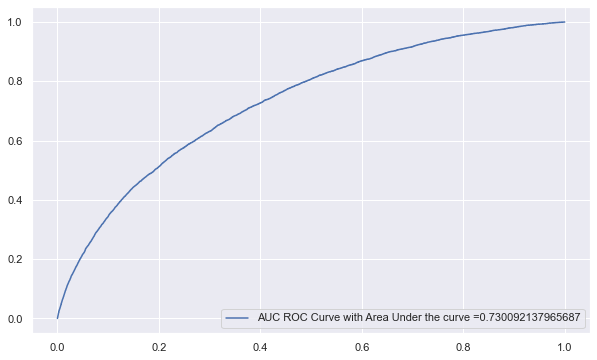

In [80]:
generate_auc_roc_curve(clf, X_valid_std, Y_valid)

## SMOTE: Oversampling

In [81]:
unique, count = np.unique(Y_train, return_counts=True)
Y_train_dict_value_count = { k:v for (k,v) in zip(unique, count)}
Y_train_dict_value_count

{0.0: 189374, 1.0: 16655}

In [91]:
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_resample(X_train_std, Y_train)

In [94]:
pd.Series(y_train_res).value_counts(normalize=True)

0.0    0.5
1.0    0.5
dtype: float64

In [175]:
clf_smote = LGBMClassifier(
                        #nthread=4,
                        n_estimators=10000,
                        learning_rate=0.02,
                        num_leaves=34,
                        colsample_bytree=0.9497036,
                        subsample=0.8715623,
                        max_depth=8,
                        reg_alpha=0.041545473,
                        reg_lambda=0.0735294,
                        min_split_gain=0.0222415,
                        min_child_weight=39.3259775,
                        verbose=-1).fit(x_train_res, y_train_res)

In [176]:
Y_valid_pred = clf_smote.predict(X_valid_std)

In [177]:
print("Validation:")
pd.crosstab(Y_valid_pred, Y_valid[target], rownames=['Predicted'], colnames=['Actual'])

Validation:


Actual,0.0,1.0
Predicted,,
0.0,92554,7763
1.0,754,407


In [178]:
generate_model_report(Y_valid, Y_valid_pred)

Accuracy = 0.916
Precision = 0.351
Recall = 0.050
F1 Score = 0.087
Fbeta Score = 0.054


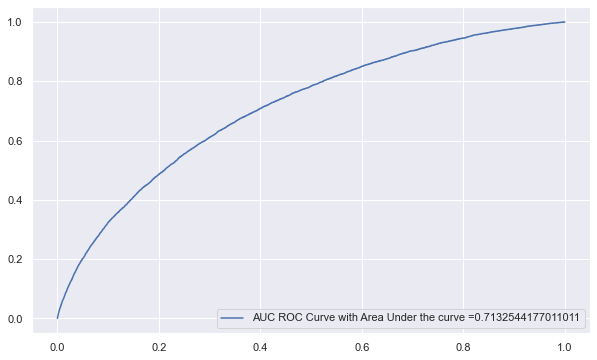

In [179]:
generate_auc_roc_curve(clf_smote, X_valid_std, Y_valid)

# Modélisation